In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import sklearn.pipeline as skpipe

In [1060]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
ff_factors = ff_factors.loc[ff_factors.index >= 196311]
ff_factors = ff_factors.loc[ff_factors.index <= 201712]

portfolio_panel = pd.read_csv('25_Portfolios_5x5.CSV', skiprows=15, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
portfolio_1_names = portfolio_panel.columns
portfolio_panel = portfolio_panel.loc[portfolio_panel.index >= 196311]
portfolio_panel = portfolio_panel.loc[portfolio_panel.index <= 201712]

portfolio370_panel = pd.read_csv('370portfolios.csv', skiprows=1, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
portfolio_2_names = portfolio370_panel.columns

In [1014]:
ff_factor_panel = ff_factors.to_numpy() / 100
# make returns excess
portfolio_return_panel = portfolio_panel.to_numpy() / 100 - ff_factor_panel[:, 3:4]
portfolio370_return_panel = portfolio370_panel.to_numpy() - ff_factor_panel[:, 3:4]

In [1015]:
panel_evals, _ = np.linalg.eigh(portfolio_return_panel.dot(portfolio_return_panel.T))
panel_evals = panel_evals[::-1]

panel370_evals, _ = np.linalg.eigh(portfolio370_return_panel.dot(portfolio370_return_panel.T))
panel370_evals = panel370_evals[::-1]

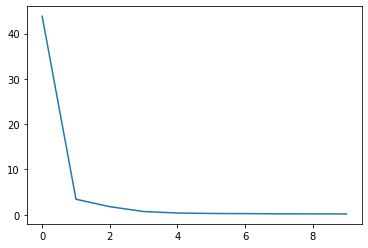

In [1016]:
plt.plot(panel_evals[:10])

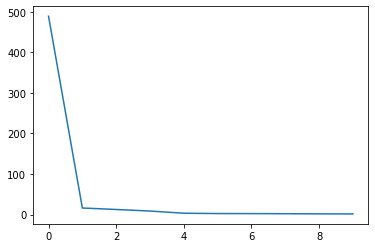

In [1017]:
plt.plot(panel370_evals[:10])

Code for parts 1-5

In [1018]:
def ic_1(N,T):
    NT = N*T
    N_plus_T = N+T

    return np.log(NT/N_plus_T) * N_plus_T/NT

def l2_loss(N,T,data_panel, pred_data):
    return (1/(N*T))*np.sum(np.square(data_panel - pred_data))

def fit_bai_ng(data_panel, K):
    T,N = data_panel.shape
    pipe = skpipe.Pipeline([('Factors', skd.TruncatedSVD(K, algorithm='arpack'))])

    lmbda = pipe.fit_transform((1/np.sqrt(T))*(data_panel - np.mean(data_panel, axis=0, keepdims=True)).T).T
    F = np.linalg.lstsq(lmbda.T, data_panel.T, rcond=None)[0].T
    
    data_hat_last = F.dot(lmbda)

    return F, lmbda, data_hat_last

def bai_ng_ev_criterion(data_panel, ic_func, max_evs=15):
    T, N = data_panel.shape
    penalized_function_resuls = []
    for i in range(1, max_evs + 1):
        F, lmbda, pred_panel = fit_bai_ng(data_panel, i)
        penalized_function_resuls.append(np.log(l2_loss(N,T,data_panel, pred_panel)) + i*ic_func(N,T))
    return penalized_function_resuls

def ahn_horenstein_evr(data_panel, max_evs=15):
    T, N = data_panel.shape
    means = np.mean(data_panel, axis=1, keepdims=True)
    evals, _ = np.linalg.eigh(data_panel.dot(data_panel.T) - means.dot(means.T)) 
    evals = evals[::-1][:max_evs]
    ratios = [x / y for x,y in zip(evals[:-1], evals[1:])]
    return ratios
    
def fit_rp_pca(data_panel, K, gamma):
    T, N = data_panel.shape
#     std_pipe = skpipe.Pipeline([('Standardize', skp.StandardScaler(with_mean=True, with_std=True))])
    fit_pipe = skpipe.Pipeline([('loadings', skd.TruncatedSVD(K, algorithm='arpack'))])
    
    r_bar = np.mean(data_panel, axis=0, keepdims=True)
    objective  = (1/(N))*data_panel.T.dot(data_panel) + (gamma)*r_bar.T.dot(r_bar)
    
    lmbda = fit_pipe.fit_transform(objective)
    print(lmbda.shape, data_panel.shape)
    F =  np.linalg.lstsq(lmbda, data_panel.T, rcond=None)[0]
    
    return F.T, lmbda.T

def onatski(data_panel, rmax=10, max_iter=100):
    T,N = data_panel.shape
    evals, _ = np.linalg.eigh(data_panel.dot(data_panel.T) / T)
    evals = evals[::-1]
    converged = False
    i = 0
    j=rmax + 1
    offset_vect = np.array([[1, -1],
                            [1, 0],
                            [1, 1],
                            [1, 2],
                            [1, 3]])
    while not converged and i < max_iter:
        i += 1
        tgt = evals[j-1:j+4]
        regressor = np.copy(offset_vect)
        regressor[:,1] += j
        regressor[:,1] = regressor[:,1]**(2/3)
        beta_hat = np.linalg.lstsq(regressor, tgt, rcond=None)[0][1]
        
        delta = 2 * np.abs(beta_hat)
        
        filtered = [i for i in range(rmax) if evals[i] - evals[i+1] >= delta]
        rhat = max(filtered) if len(filtered) > 0 else 0
        j_new = rhat + 1
        converged =  j_new == j
        j = j_new
    return j

###  1

5


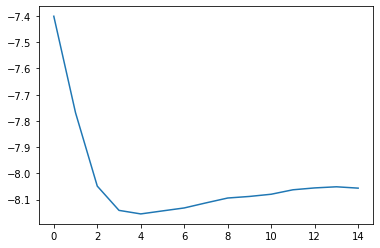

In [1019]:
by_factor_ic = bai_ng_ev_criterion(portfolio_return_panel, ic_1)
print(np.argmin(by_factor_ic) + 1)
plt.plot(by_factor_ic)    

We see that in this case (the first information criterion function in Bai and Ng) we select k = 5 factors

13


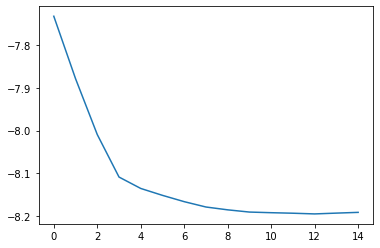

In [1038]:
by_factor_ic = bai_ng_ev_criterion(portfolio370_return_panel, ic_1)
print(np.argmin(by_factor_ic) + 1)
plt.plot(by_factor_ic)

We see that in this case (the first information criterion function in Bai and Ng) we select k = 13 factors

### 2

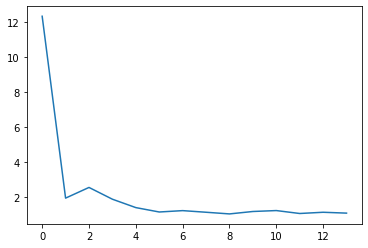

In [1040]:
byf_factor_evr = ahn_horenstein_evr(portfolio_return_panel)
plt.plot(byf_factor_evr)

In this case we would select k=2 factors

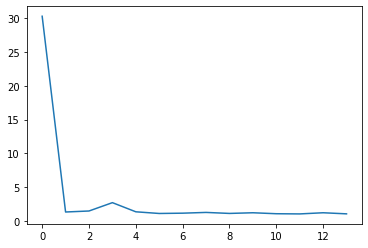

In [1022]:
byf_factor_evr = ahn_horenstein_evr(portfolio370_return_panel)
plt.plot(byf_factor_evr)

In this case we would select k=3 factors

### 3

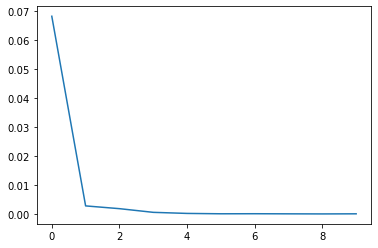

(1, 1)

In [1078]:
plt.plot((panel_evals[:10] - panel_evals[1:11])/np.sum(panel370_evals))
plt.show()
onatski(portfolio_return_panel, rmax=10), onatski(portfolio_return_panel, rmax=20)

in this case we would select k=1 factor, we see that the choice is robust between rmax = 10 or 20

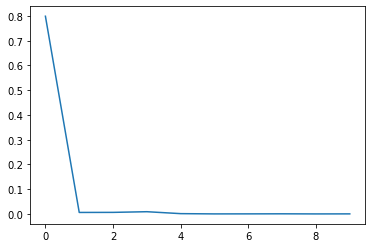

In [1052]:
plt.plot((panel370_evals[:10] - panel370_evals[1:11])/np.sum(panel370_evals))

In [1080]:
onatski(portfolio370_return_panel, rmax=10), onatski(portfolio370_return_panel, rmax=20)

(4, 4)

in this case we would selct k=4 factors

### 4

In [1050]:
pca_factors_25, pca_loadings_25, _ = fit_bai_ng(portfolio_return_panel, 3)
pca_factors_370, pca_loadings_370, _ = fit_bai_ng(portfolio370_return_panel, 5)

### 5

In [1051]:
rp_pca_factors_25, rp_pca_loadings_25 = fit_rp_pca(portfolio_return_panel, 3, gamma=20)
rp_pca_factors_370, rp_pca_loadings_370 = fit_rp_pca(portfolio370_return_panel, 5, gamma=20)

(25, 3) (650, 25)
(370, 5) (650, 370)


### 6

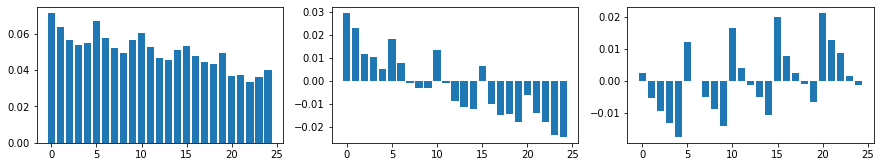

In [1027]:
fig, axs = plt.subplots(1,3,figsize=(15,2.5))
for i in range(3):
    axs[i].bar(np.arange(25), pca_loadings_25[i])
plt.show()

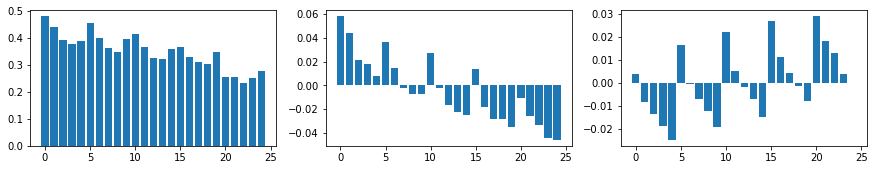

In [1028]:
fig, axs = plt.subplots(1,3,figsize=(15,2.5))
for i in range(3):
    axs[i].bar(np.arange(25), rp_pca_loadings_25[i])
plt.show()

In [1059]:
portfolio_1_names

Index(['SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'SMALL HiBM', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4',
       'BIG HiBM'],
      dtype='object')

In the case of the 25 factors, rp\_pca and pca fit very similat factors. The first is clearly a market factor, the second is long small / low book to market stocks and moves somewhat linearly to short as btm/size increase. the spikes are whenever we switch from high book to market to low. The third factor is long small stocks, short low btm stocks.

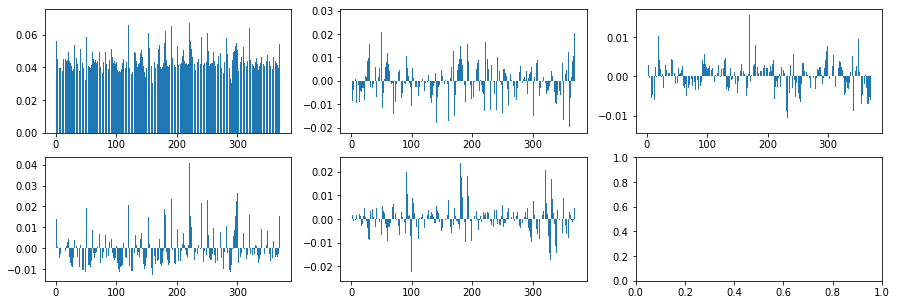

In [1029]:
fig, axs = plt.subplots(2,3, figsize=(15,5))
for i in range(5):
    axs[i%2][i//2].bar(np.linspace(1, 370, 370), pca_loadings_370[i])
plt.show()

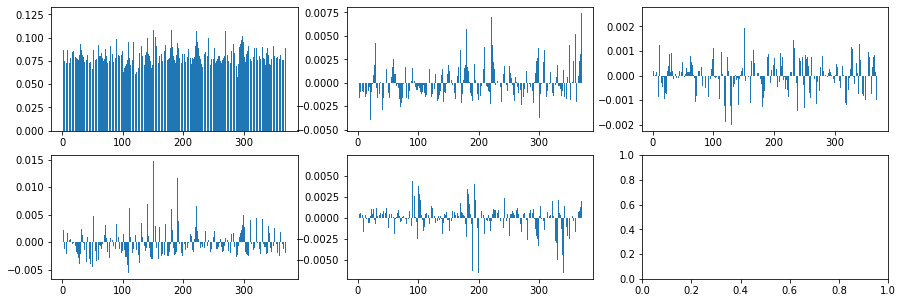

In [1030]:
fig, axs = plt.subplots(2,3, figsize=(15,5))
for i in range(5):
    axs[i%2][i//2].bar(np.linspace(1, 370, 370), rp_pca_loadings_370[i])
plt.show()

In [1063]:
print(', '.join(portfolio_2_names))

p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p1.1, p2.1, p3.1, p4.1, p5.1, p6.1, p7.1, p8.1, p9.1, p10.1, p1.2, p2.2, p3.2, p4.2, p5.2, p6.2, p7.2, p8.2, p9.2, p10.2, p1.3, p2.3, p3.3, p4.3, p5.3, p6.3, p7.3, p8.3, p9.3, p10.3, p1.4, p2.4, p3.4, p4.4, p5.4, p6.4, p7.4, p8.4, p9.4, p10.4, p1.5, p2.5, p3.5, p4.5, p5.5, p6.5, p7.5, p8.5, p9.5, p10.5, p1.6, p2.6, p3.6, p4.6, p5.6, p6.6, p7.6, p8.6, p9.6, p10.6, p1.7, p2.7, p3.7, p4.7, p5.7, p6.7, p7.7, p8.7, p9.7, p10.7, p1.8, p2.8, p3.8, p4.8, p5.8, p6.8, p7.8, p8.8, p9.8, p10.8, p1.9, p2.9, p3.9, p4.9, p5.9, p6.9, p7.9, p8.9, p9.9, p10.9, p1.10, p2.10, p3.10, p4.10, p5.10, p6.10, p7.10, p8.10, p9.10, p10.10, p1.11, p2.11, p3.11, p4.11, p5.11, p6.11, p7.11, p8.11, p9.11, p10.11, p1.12, p2.12, p3.12, p4.12, p5.12, p6.12, p7.12, p8.12, p9.12, p10.12, p1.13, p2.13, p3.13, p4.13, p5.13, p6.13, p7.13, p8.13, p9.13, p10.13, p1.14, p2.14, p3.14, p4.14, p5.14, p6.14, p7.14, p8.14, p9.14, p10.14, p1.15, p2.15, p3.15, p4.15, p5.15, p6.15, p7.15, p8.15,

These are naturally a little harder to visually interprit, although we can certainly say that the first is a market factor. We can in this case, however, see a clear difference bewteen pca and rp-pca emerging.

### 7

In [1031]:
def sharpe(series):
    return np.mean(series) / np.std(series)


def sharpe_factors(factors_t_n):
    mu_f = np.mean(factors_t_n, axis=0, keepdims=True)
    return np.sqrt(mu_f.dot(np.linalg.inv(np.cov(factors_t_n.T))).dot(mu_f.T))

def markowitz(panel_t_n):
    T,N = panel_t_n.shape
    mu = np.mean(panel_t_n, axis=0, keepdims=True)
    
    cov = np.cov(panel_t_n.T)
    if N > 1:
        return np.linalg.inv(cov).dot(mu.T)
    else:
        return mu.T / cov

def sharpe_of_factors(factors):
    portfolio = markowitz(factors)
    return sharpe(factors.dot(portfolio))

market factor

In [1032]:
sharpe_of_factors(ff_factor_panel[:,0:1])

0.11964372062827072

fama french 3 factor

In [1033]:
sharpe_factors(ff_factor_panel[:,0:3])

array([[0.2072842]])

pca 3 factors

In [1034]:
sharpe_factors(pca_factors_25)

array([[0.21833483]])

rp-pca 3 factors

In [1035]:
sharpe_factors(rp_pca_factors_25)

array([[0.22187965]])

pca 5 factors second portfolios

In [1036]:
sharpe_factors(pca_factors_370)

array([[0.24663223]])

rp-pca 5 factors second portfolios

In [1037]:
sharpe_factors(rp_pca_factors_370)

array([[0.57723402]])

###  8

In [959]:
import scipy as scp

In [981]:
def time_series_ap_test(factors, test_assets):
    T, N = test_assets.shape
    _, K = factors.shape
    ones_T = np.ones((T,1))
    loadings = np.linalg.lstsq(np.concatenate([ones_T, factors], axis=1),
                    test_assets, rcond=None)[0]
    alphas = loadings[0:1, :]
    betas = loadings[1:, :]
    
    residuals = test_assets - np.concatenate([ones_T, factors], axis=1).dot(loadings)
    f_bar = np.mean(factors, axis=0, keepdims=True)
    
    if K == 1:
        omega = (1/T)*sum([(factors[t:t+1,:] - f_bar).T.dot(factors[t:t+1,:] - f_bar) for t in range(T)])
    else:
        omega = np.cov(factors.T)

    sigma_hat = (1/T)*sum([residuals[i:i+1,:].T.dot(residuals[i:i+1,:]) for i in range(T)]) * np.eye(N)
    
    fscore = ((T - N - K) / N) * ((1 + f_bar.dot(np.linalg.inv(omega)).dot(f_bar.T))**(-1)) * \
        (alphas.dot(np.linalg.inv(sigma_hat)).dot(alphas.T))
    fscore = fscore[0][0]
    
    p = 1-scp.stats.f.cdf(fscore, N, T - N - K) #find p-value of F test statistic 
    print({
        "p value": p,
        "f score": fscore,
        "df1": N,
        "df2": T-K-N,
    })
    return p, fscore, N, T - N - K
    

market factor, 25 portfolios

In [982]:
_ = time_series_ap_test(ff_factor_panel[:,0:1], portfolio_return_panel)


{'p value': 3.3306690738754696e-16, 'f score': 5.687256129620094, 'df1': 25, 'df2': 624}


ff 3 factors, 25 portfolios

In [984]:
_ = time_series_ap_test(ff_factor_panel[:,0:3], portfolio_return_panel)

{'p value': 4.059543146084366e-09, 'f score': 3.75697833967705, 'df1': 25, 'df2': 622}


pca factors, 25 portfolios

In [985]:
_ = time_series_ap_test(pca_factors_25, portfolio_return_panel)


{'p value': 2.9760638398101946e-12, 'f score': 4.615951573327762, 'df1': 25, 'df2': 622}


rp-pca factors, 25 portfolios

In [986]:
_ = time_series_ap_test(rp_pca_factors_25, portfolio_return_panel)


{'p value': 6.186828827026147e-12, 'f score': 4.529720391307021, 'df1': 25, 'df2': 622}


pca factors, 370 portfolios

In [987]:
_ = time_series_ap_test(pca_factors_370, portfolio370_return_panel)


{'p value': 8.043448616046334e-07, 'f score': 1.736326068441845, 'df1': 370, 'df2': 275}


rp-pca factors, 370 portfolios

In [988]:
_ = time_series_ap_test(rp_pca_factors_370, portfolio370_return_panel)


{'p value': 0.020416396615084986, 'f score': 1.2619538042259923, 'df1': 370, 'df2': 275}


###  9

In [997]:
def xs_ap_test(factors, test_assets):
    T, N = test_assets.shape
    _, K = factors.shape
    ones_T = np.ones((T,1))
    loadings = np.linalg.lstsq(np.concatenate([ones_T, factors], axis=1),
                    test_assets, rcond=None)[0]
    a_s = loadings[0:1, :]
    betas = loadings[1:, :]
    print(betas.shape)
    resids = test_assets - np.concatenate([ones_T, factors], axis=1).dot(loadings)
    
    Sigma = np.eye(N) * np.cov(resids.T)
    
    Sigma_F = np.cov(factors.T)

    expected_returns = np.mean(test_assets, axis=0)
    ones_N = np.ones((N,1))
    lambdas = np.linalg.lstsq(betas.T, expected_returns, rcond=None)[0]
    alphas = expected_returns.T - betas.T.dot(lambdas)
    
    in_minus_beta = np.eye(N) - betas.T.dot(np.linalg.inv(betas.dot(betas.T))).dot(betas)
    
    if factors.shape[1] > 1:
        shanken_correction = 1 + lambdas.T.dot(np.linalg.inv(Sigma_F)).dot(lambdas)
#         shanken_correction = 1
    else:
        shanken_correction = 1 + lambdas.T.dot(lambdas) / (Sigma_F)

#         shanken_correction = 1
    
    cov_alpha = (1/T) * in_minus_beta.dot(Sigma).dot(in_minus_beta.T) * shanken_correction 
    score = alphas.T.dot(cov_alpha).dot(alphas)
    p = 1-chi2.cdf(score, N-K) #find p-value
    print({
        "p value": p,
        "score": score,
        "df": N-K,
    })
    return p, score, N - K
    

In [998]:
from scipy.stats.distributions import chi2

In [999]:
from linearmodels.asset_pricing.model import LinearFactorModel

In [1000]:
lfm = LinearFactorModel(portfolio_return_panel, ff_factor_panel[:,0:1])
lfm_fit = lfm.fit()

In [1001]:
lfm_fit

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.7275
No. Factors:                          1   J-statistic:                    115.56
No. Observations:                   650   P-value                         0.0000
Date:                  Wed, Mar 03 2021   Distribution:                 chi2(24)
Time:                          20:04:27                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor         0.6627     0.1857     3.5694     0.0004      0.2988      1.0266
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
LinearFactorModelResults, id: 0x1a458afd68

In [1002]:
lfm = LinearFactorModel(portfolio_return_panel, ff_factor_panel[:,0:3])
lfm_fit = lfm.fit( debiased=True)
lfm_fit

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.9157
No. Factors:                          3   J-statistic:                    94.059
No. Observations:                   650   P-value                         0.0000
Date:                  Wed, Mar 03 2021   Distribution:                 chi2(22)
Time:                          20:04:27                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor.0       0.5046     0.1751     2.8817     0.0040      0.1614      0.8479
factor.1       0.1911     0.1232     1.5504     0.1210     -0.0505      0.4326
factor.2       0.4071     0.1144     3.5593     0.0004      0.1829      0.6313
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
LinearFactorModelResults, id: 0x1a5676b710

market factors, 25 portfolios

In [1008]:
_ = xs_ap_test(ff_factor_panel[:,0:1], portfolio_return_panel)

(1, 25)
{'p value': 1.0, 'score': 3.414303463356029e-10, 'df': 24}


ff 3 factors, 25 portfolios

In [1009]:
_ = xs_ap_test(ff_factor_panel[:,0:3], portfolio_return_panel)

(3, 25)
{'p value': 1.0, 'score': 3.101863737637997e-11, 'df': 22}


pca factors, 25 portfolios

In [1010]:
_ = xs_ap_test(pca_factors_25, portfolio_return_panel)

(3, 25)
{'p value': 1.0, 'score': 1.990960861796633e-11, 'df': 22}


rp-pca factors, 25 portfolios

In [1011]:
_ = xs_ap_test(rp_pca_factors_25, portfolio_return_panel)


(3, 25)
{'p value': 1.0, 'score': 1.935256194220642e-11, 'df': 22}


pca factors, 370 portfolios

In [1012]:
_ = xs_ap_test(pca_factors_370, portfolio370_return_panel)

(5, 370)
{'p value': 1.0, 'score': 4.2356681111082273e-10, 'df': 365}


rp-pca factors, 370 portfolios

In [1013]:
_ = xs_ap_test(rp_pca_factors_370, portfolio370_return_panel)


(5, 370)
{'p value': 1.0, 'score': 2.6022219702128646e-10, 'df': 365}


###  10

In [857]:
mkt_loadings = np.linalg.lstsq(ff_factor_panel[:,0:1], portfolio_return_panel, rcond=None)[0]

In [858]:
ff_25_loadings = np.linalg.lstsq(ff_factor_panel[:,0:3], portfolio_return_panel, rcond=None)[0]

In [1070]:
def plot_er_vs_pred_er(factors, loadings, returns):
    expected_returns = np.mean(returns, axis=0)
    mean_predicted_return = np.mean(factors@loadings, axis=0)
    
    m, b = np.polyfit(expected_returns, mean_predicted_return, 1)

    plt.plot(expected_returns, mean_predicted_return, 'o')

    plt.plot(expected_returns, m*expected_returns + b)
    plt.ylabel("predicted")
    plt.ylabel("expected")
    plt.show()

market factor, 25 portfolios

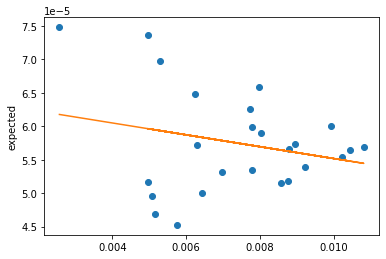

In [1071]:
plot_er_vs_pred_er(ff_factor_panel[:,0:1], mkt_loadings, portfolio_return_panel)



ff 3 factors, 25 portfolios

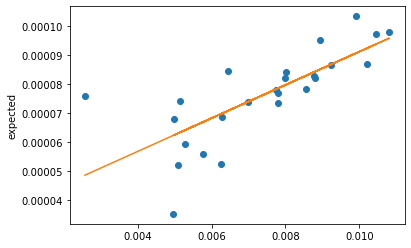

In [1072]:
plot_er_vs_pred_er(ff_factor_panel[:,0:3], ff_25_loadings, portfolio_return_panel)


pca factors, 25 portfolios

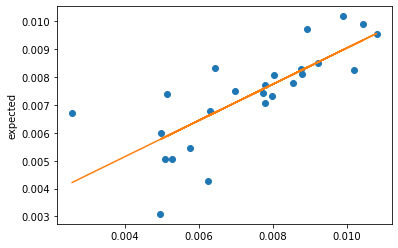

In [1073]:
plot_er_vs_pred_er(pca_factors_25, pca_loadings_25, portfolio_return_panel)

rp-pca factors, 25 portfolios

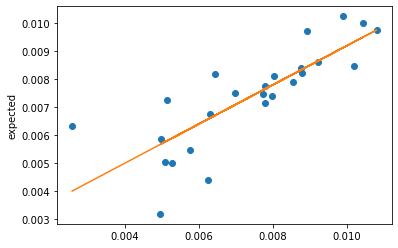

In [1075]:
plot_er_vs_pred_er(rp_pca_factors_25, rp_pca_loadings_25, portfolio_return_panel)


pca factors, 370 portfolios

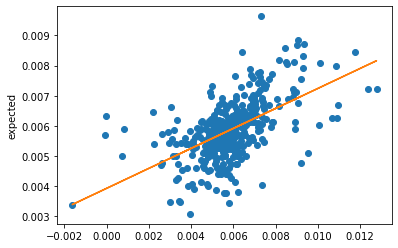

In [1076]:
plot_er_vs_pred_er(pca_factors_370, pca_loadings_370, portfolio370_return_panel)

rp-pca factors, 370 portfolios

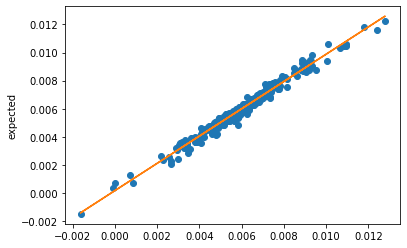

In [1077]:
plot_er_vs_pred_er(rp_pca_factors_370, rp_pca_loadings_370, portfolio370_return_panel)

### 11

#### Part 7
The results here are largely what we expect rp-pca slightly betas pca in the small K/N setting, however it dominates it in the high dimensional setting. On the 25 portfolio case, we see that the statistical factors are slightly better than the FF french ones, however they are very close. This is by construction, we are forming portfolios based on the stock characteristics from which two of those three factors are derived.


#### Part 8
For the 25 portfolios, we saw that the time series alphas were statistically significantly  nonzero for all sets of factors. For the 370 portfolios, we saw that while the alphas for the PCA factors statistically significantly  nonzero, the alpha for the RP-PCA factors were statistically significantly nonzero at 5 \%, but not at 1 \%


#### Part 9
For this test, we saw that the alphas for the cross sectiontional asset pricing test were not statistically significantly different than zero for any of the sets of factors or test portfolios


#### Part 10
For part 10, we see that the average return predicted by the market factor is not at all forming a straight line with the portfolios. This is expected. For the other three sets of factors, we see that they get the trend right, but that there is still a lot of variation around the average predicted return. This confirms our suspicion based on the similarities of the sharpe ratios of the factors that they price the 25 portfolios reasonably similarly. PCA get's the trend right for the average return of the 370 anomaly portfolios, however there is still a lot of variation around that line. RP-PCA is clearly superior in terms of average return vs mean predicted return for the anomaly portfolios, this is in line with the fact that the alphas for the rp-pca factors for the time series regression test were not statistically significant at the 1 % level. 